In this notebook, i tried to predict the open price of Tesla Stock by simple RNN Model and LSTM model.<br>
Those who want to have detailed info on simple RNN and LSTM, may refer to great post below:<br>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/


* [1. Loading Data](#1) <br>
* [2.Spliting Data as Train and Validation](#2) <br>
* [3.Creating Train Dataset from Train split](#3) <br>
* [4.Normalization / Feature Scaling](#4) <br>
* [5.Creating X_train and y_train from Train data](#5) <br>
* [6.Creating Simple RNN model](#6) <br>
* [7.Evaluating Model](#7) <br>
* [8.Creating Test Dataset from Validation Data](#8) <br>
* [9.Evaluating with Validation Data](#9) <br>
* [10.Creating LSTM model](#10) <br>
* [11.Evaluating LSTM model](#11) <br>
* [12.Future price prediction](#12) <br>


<a id="1"></a>
## 1.Loading Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
data = pd.read_csv("Tesla.csv")

In [6]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


<a id="2"></a>
## 2.Spliting Data as Train and Validation

In [8]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 1692
Train data length : 1184
Validation data lenth : 508


In [11]:
train_data = data[:length_train].iloc[:,:2] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Open
0,2010-06-29,19.000000
1,2010-06-30,25.790001
2,2010-07-01,25.000000
3,2010-07-02,23.000000
4,2010-07-06,20.000000
...,...,...
1179,2015-03-06,199.210007
1180,2015-03-09,194.389999
1181,2015-03-10,188.460007
1182,2015-03-11,191.149994


In [12]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Open
1184,2015-03-13,188.949997
1185,2015-03-16,192.000000
1186,2015-03-17,195.429993
1187,2015-03-18,194.960007
1188,2015-03-19,202.000000
...,...,...
1687,2017-03-13,244.820007
1688,2017-03-14,246.110001
1689,2017-03-15,257.000000
1690,2017-03-16,262.399994


<a id="3"></a>
## 3.Creating Train Dataset from Train split

* We will get Open column as our dataset
* Dataset to be converted to array by adding `.values`

In [13]:
dataset_train = train_data.Open.values
dataset_train.shape

(1184,)

In [14]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(1184, 1)

#### <a id="4"></a>
## 4.Normalization / Feature Scaling

* Dataset values will be in between 0 and 1 after scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(1184, 1)

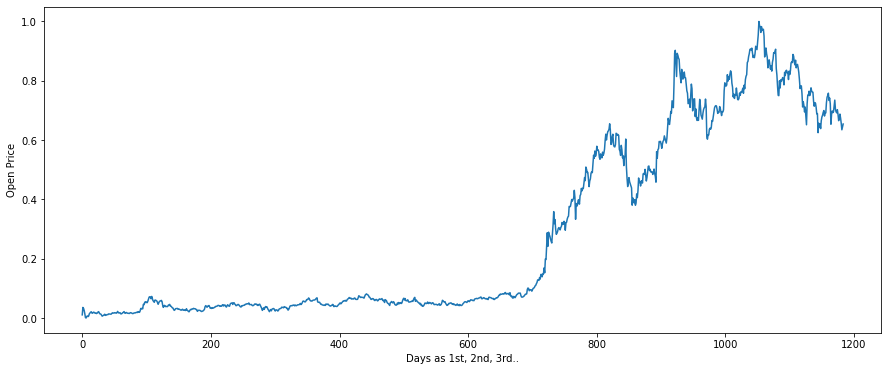

In [16]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

<a id="5"></a>
## 5.Creating X_train and y_train from Train data

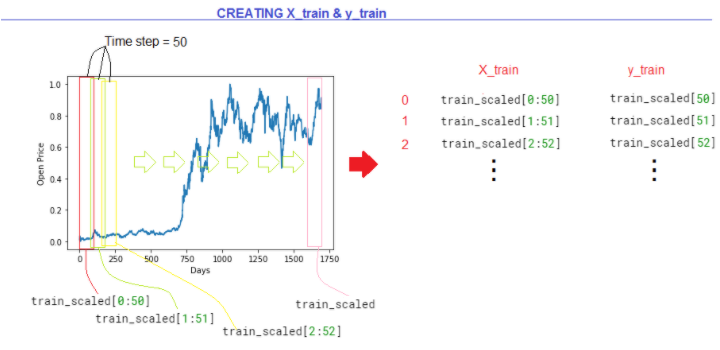

* We have train data composed of stock open prices over days
* So, it has 1184 prices corresponding 1184 days
* My aim is to predict the open price of the next day.
* I can use a time step of 50 days.
* I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
* Then predict the price of 51th day; and 51th price will be in y_train data
* Again, i will pick prices from 1 to 51, those will be in X_train data
* Then predict the next days price, 52nd price will be in y_train data

In [17]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)


In [18]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1134, 50)
Shape of y_train before reshape : (1134,)


## Reshape

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (1134, 50, 1)
Shape of y_train after reshape : (1134, 1)


* Shape of X_train : 1134 x 50 x 1
* That means we have 1134 rows, each row has 50 rows and 1 column
* Lets check the first row: it has 50 rows (open prices of 49 days)

In [20]:
X_train

array([[[0.01053291],
        [0.03553936],
        [0.03262991],
        ...,
        [0.01741981],
        [0.01646228],
        [0.01664641]],

       [[0.03553936],
        [0.03262991],
        [0.02526425],
        ...,
        [0.01646228],
        [0.01664641],
        [0.01789858]],

       [[0.03262991],
        [0.02526425],
        [0.01421574],
        ...,
        [0.01664641],
        [0.01789858],
        [0.01697787]],

       ...,

       [[0.74993553],
        [0.75634363],
        [0.7761941 ],
        ...,
        [0.68762198],
        [0.67421647],
        [0.65646518]],

       [[0.75634363],
        [0.7761941 ],
        [0.76547709],
        ...,
        [0.67421647],
        [0.65646518],
        [0.634626  ]],

       [[0.7761941 ],
        [0.76547709],
        [0.76216251],
        ...,
        [0.65646518],
        [0.634626  ],
        [0.64453278]]])

* Check the first item in y_train
* It is the price of 50th day

In [21]:
y_train[0]

array([0.01789858])

<a id="6"></a>
## 6.Creating RNN model 

In [22]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
36/36 [==============================] - 10s 57ms/step - loss: 0.3977 - accuracy: 8.8183e-04
Epoch 2/50
36/36 [==============================] - 2s 67ms/step - loss: 0.1972 - accuracy: 8.8183e-04
Epoch 3/50
36/36 [==============================] - 2s 62ms/step - loss: 0.1246 - accuracy: 8.8183e-04
Epoch 4/50
36/36 [==============================] - 2s 60ms/step - loss: 0.0896 - accuracy: 8.8183e-04
Epoch 5/50
36/36 [==============================] - 2s 61ms/step - loss: 0.0669 - accuracy: 0.0000e+00
Epoch 6/50
36/36 [==============================] - 2s 60ms/step - loss: 0.0525 - accuracy: 8.8183e-04
Epoch 7/50
36/36 [==============================] - 2s 54ms/step - loss: 0.0533 - accuracy: 0.0000e+00
Epoch 8/50
36/36 [==============================] - 2s 53ms/step - loss: 0.0431 - accuracy: 0.0000e+00
Epoch 9/50
36/36 [==============================] - 2s 56ms/step - loss: 0.0389 - accuracy: 8.8183e-04
Epoch 10/50
36/36 [==============================] - 2s 58ms/step - loss

<a id="7"></a>
## 7.Evaluating Model

In [23]:
# Losses
history.history["loss"]

[0.39773064851760864,
 0.19716346263885498,
 0.1245623379945755,
 0.08957946300506592,
 0.06694263219833374,
 0.052457377314567566,
 0.05331259220838547,
 0.04305332899093628,
 0.03894887492060661,
 0.030075987800955772,
 0.028931323438882828,
 0.028018968179821968,
 0.02464686892926693,
 0.020569171756505966,
 0.02161690592765808,
 0.017870057374238968,
 0.019446339458227158,
 0.015913868322968483,
 0.016699451953172684,
 0.014037968590855598,
 0.013341816142201424,
 0.012951585464179516,
 0.010903102345764637,
 0.011513681150972843,
 0.01053442619740963,
 0.011095582507550716,
 0.008680195547640324,
 0.008679702877998352,
 0.008751885034143925,
 0.008353116922080517,
 0.008578209206461906,
 0.008658607490360737,
 0.007786918897181749,
 0.0067570083774626255,
 0.006078572012484074,
 0.006030241027474403,
 0.005888678133487701,
 0.0066101751290261745,
 0.005310561507940292,
 0.005697614047676325,
 0.004929868970066309,
 0.006067566107958555,
 0.005350531544536352,
 0.005416573956608772

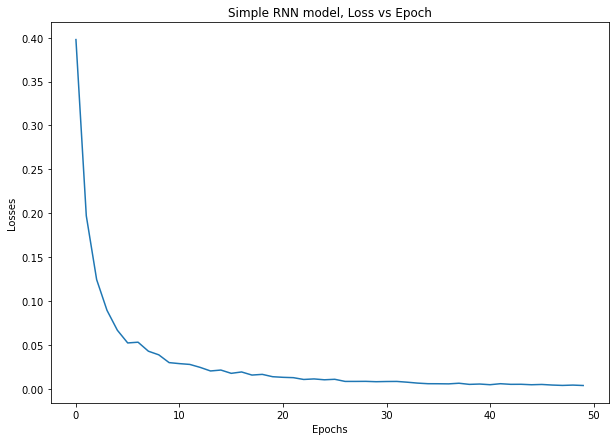

In [24]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

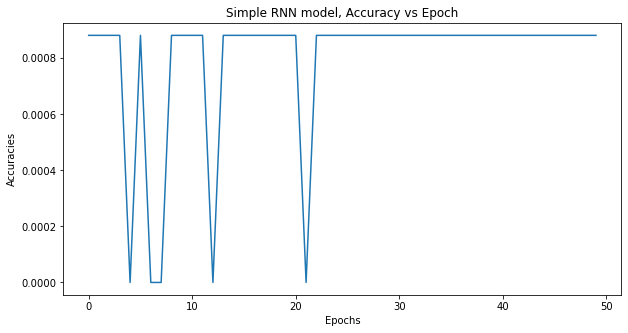

In [25]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

## Model predictions for train data 

In [26]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

36/36 [==============================] - 2s 22ms/step


(1134, 1)

In [27]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(1134, 1)

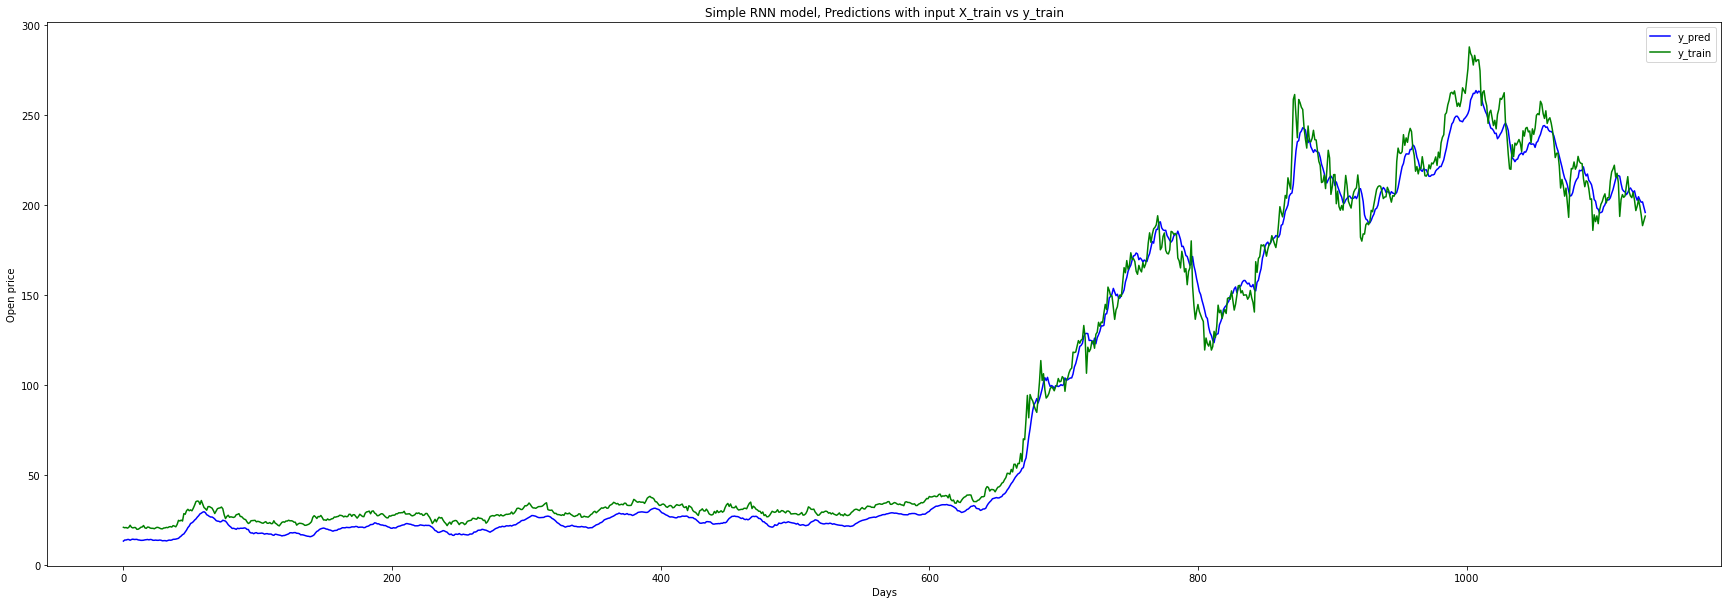

In [28]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()


<a id="8"></a>
## 8.Creating Test Dataset from Validation Data 

### Converting array and scaling

In [29]:
dataset_validation = validation_data.Open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (508, 1)


### Creating X_test and y_test

In [30]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

### Converting to array

In [31]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [32]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (458, 50)
Shape of y_test before reshape : (458,)


### Reshape

In [33]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [34]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (458, 50, 1)
Shape of y_test after reshape : (458, 1)


<a id="9"></a>
## 9.Evaluating with Validation Data 

In [35]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

15/15 [==============================] - 0s 21ms/step
Shape of y_pred_of_test : (458, 1)


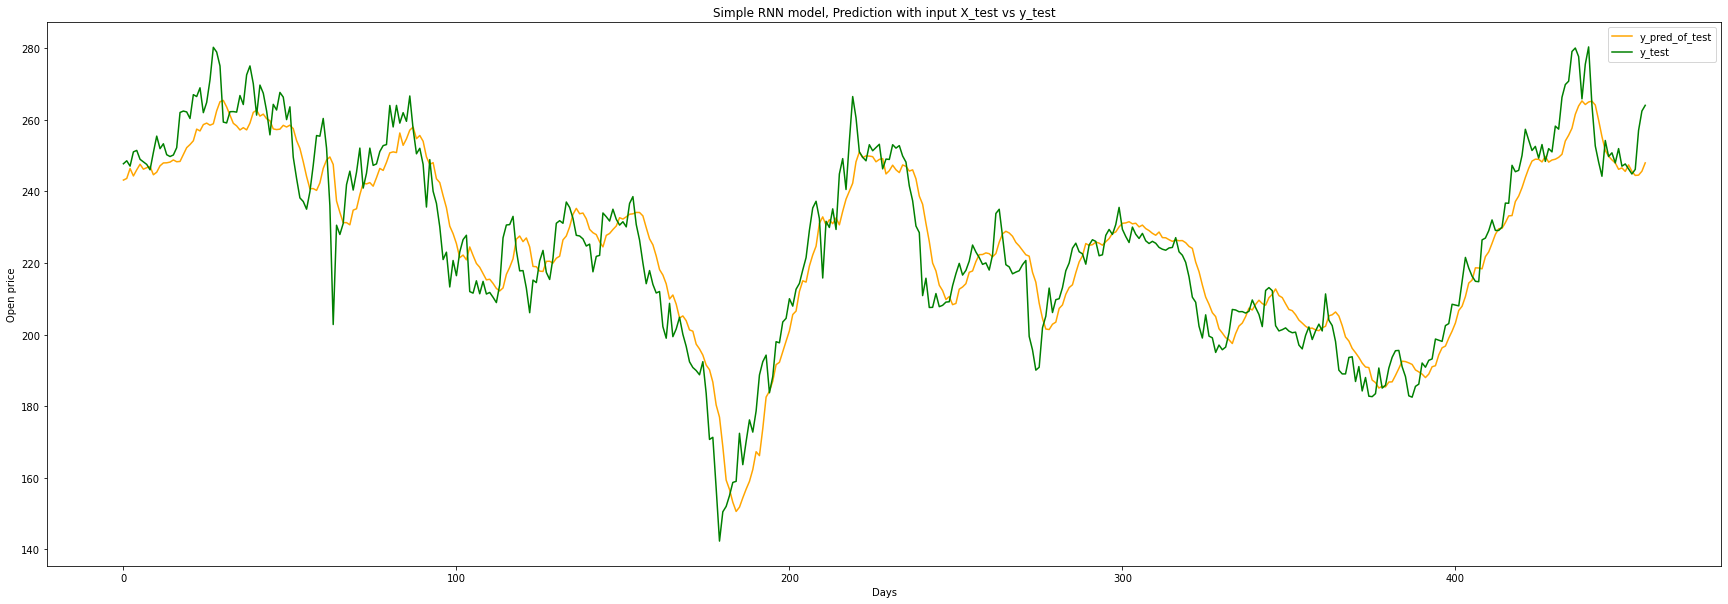

In [36]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

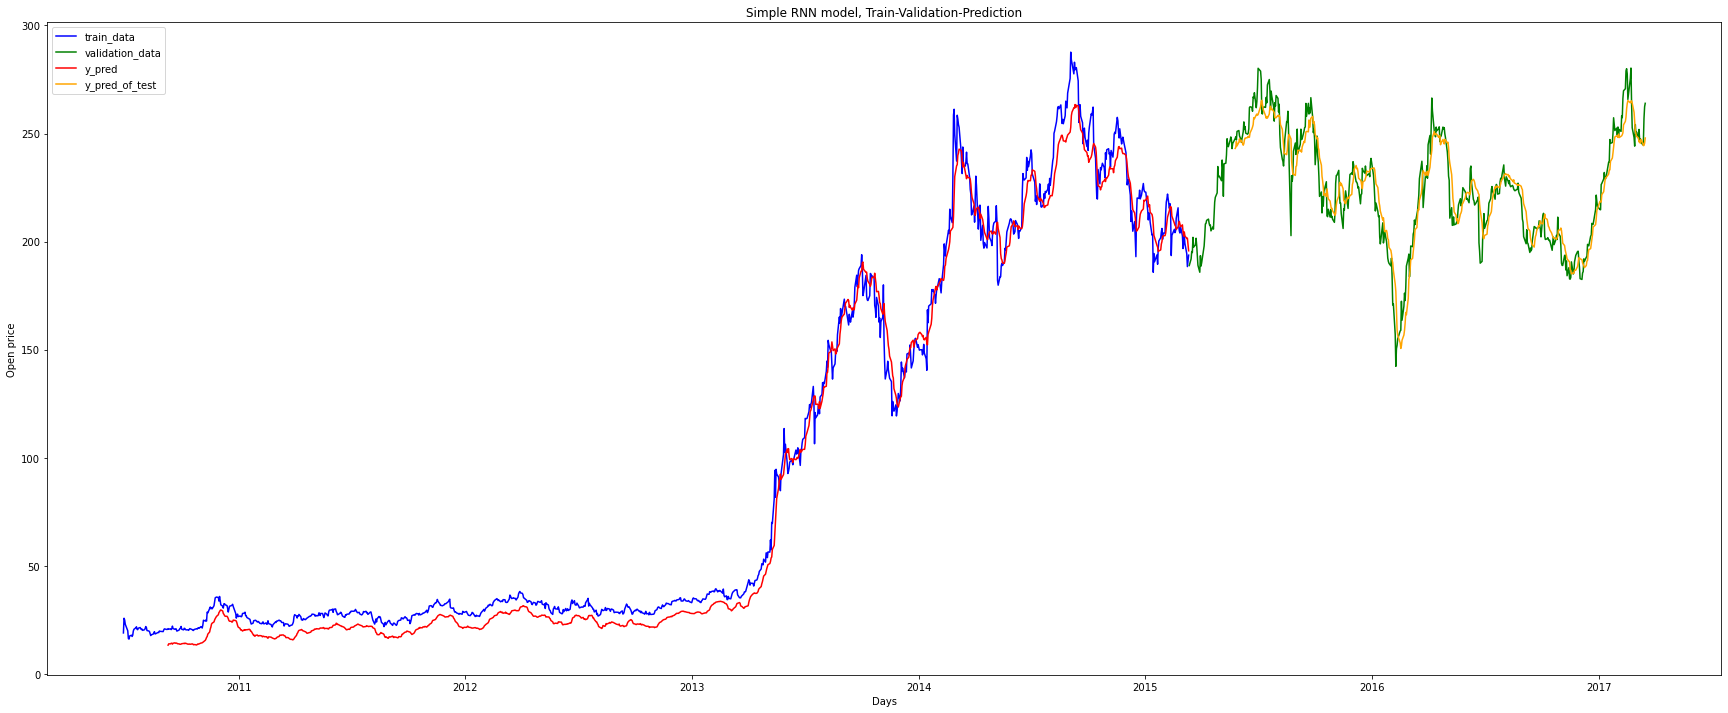

In [37]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

<a id="10"></a>
## 10.Creating LSTM Model

In [38]:
y_train = scaler.fit_transform(y_train)

In [39]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)


Epoch 1/10
114/114 [==============================] - 15s 55ms/step - loss: 0.0043 - accuracy: 0.0018
Epoch 2/10
114/114 [==============================] - 7s 59ms/step - loss: 0.0011 - accuracy: 0.0018
Epoch 3/10
114/114 [==============================] - 6s 52ms/step - loss: 0.0010 - accuracy: 0.0018
Epoch 4/10
114/114 [==============================] - 7s 57ms/step - loss: 0.0011 - accuracy: 0.0018
Epoch 5/10
114/114 [==============================] - 6s 56ms/step - loss: 7.5886e-04 - accuracy: 0.0018
Epoch 6/10
114/114 [==============================] - 6s 55ms/step - loss: 7.0885e-04 - accuracy: 0.0018
Epoch 7/10
114/114 [==============================] - 7s 59ms/step - loss: 7.4077e-04 - accuracy: 0.0018
Epoch 8/10
114/114 [==============================] - 7s 63ms/step - loss: 8.2951e-04 - accuracy: 0.0018
Epoch 9/10
114/114 [==============================] - 6s 57ms/step - loss: 6.3434e-04 - accuracy: 0.0018
Epoch 10/10
114/114 [==============================] - 6s 54ms/step - 

<a id="11"></a>
## 11.Evaluating LSTM Model

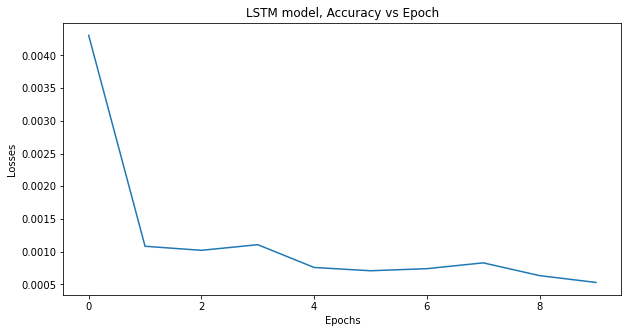

In [40]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

15/15 [==============================] - 3s 31ms/step


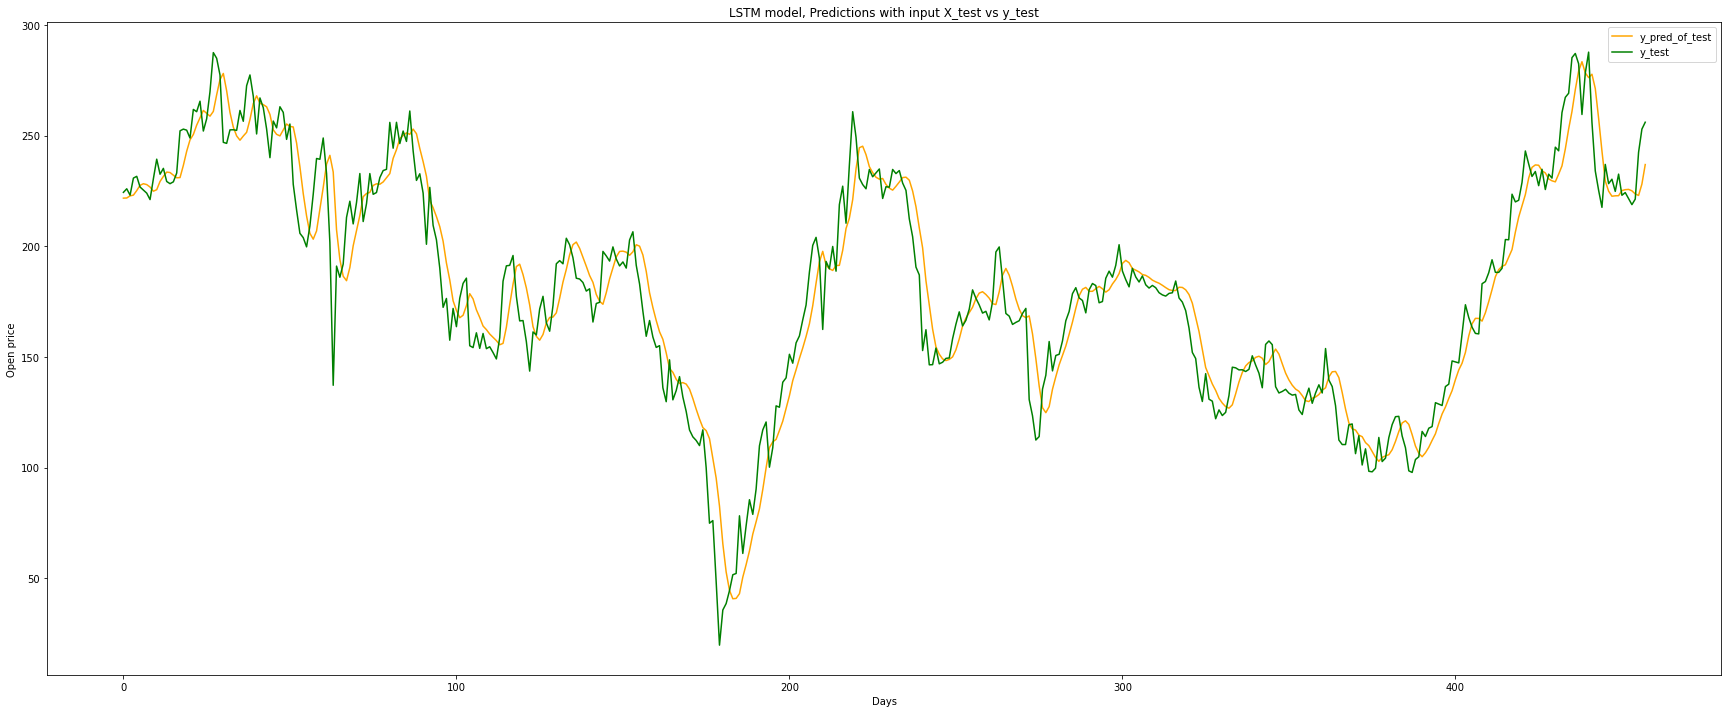

In [41]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

<a id="12"></a>
## 12.Future price prediction

* Which day is the last day in our data?

In [42]:
data.iloc[-1]

Date          3/17/2017
Open              264.0
High         265.329987
Low          261.200012
Close             261.5
Volume          6475900
Adj Close         261.5
Name: 1691, dtype: object

* We can predict the open price for the day after 3/17/2017--> for  3/18/2017.
* We will use last 50 days Open price as input of our model for this prediction
* Let us prepare it:

In [43]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.        ],
        [0.00946363],
        [0.04731867],
        [0.10354429],
        [0.04917441],
        [0.04898868],
        [0.06643166],
        [0.19075893],
        [0.18983106],
        [0.38652815],
        [0.35331247],
        [0.36054942],
        [0.43755803],
        [0.57320468],
        [0.5171645 ],
        [0.46316584],
        [0.48450549],
        [0.42345532],
        [0.49415485],
        [0.40675446],
        [0.47300067],
        [0.45611434],
        [0.58953431],
        [0.57394708],
        [0.7390982 ],
        [0.80478773],
        [0.82241588],
        [0.97624793],
        [0.99424758],
        [0.94971253],
        [0.73074763],
        [0.90981655],
        [1.        ],
        [0.69734648],
        [0.48691791],
        [0.40359993],
        [0.32974585],
        [0.51512331],
        [0.43217682],
        [0.45128979],
        [0.39877539],
        [0.47318612],
        [0.38188907],
        [0.39357964],
        [0.36722971],
        [0

In [39]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 3/18/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 3/18/2017 :", LSTM_prediction[0,0])

Simple RNN, Open price prediction for 3/18/2017      : 250.00018
LSTM prediction, Open price prediction for 3/18/2017 : 255.20789


## Thanks for reading, please upvote:)